# Load tfrecords, define model and train

In [23]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from keras import layers
from keras import models

#Tensorboard
%load_ext tensorboard


# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint
import datetime        
from scipy.io.wavfile import write
import random


# Check if the GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")



Tensorflow Version: 2.9.1
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
GPU not available :(


In [2]:
# load global settings in config-dictionary
with open('./MA_CONFIG.json', 'r') as fp:
  config = json.load(fp)

# define some extra values
config['batch_size'] = 16
config['shuffle_buffer_size'] = 300

# print config
#print(json.dumps(config, indent=4))

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)


# funcs 

In [3]:
# autotune for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# decode tfrecords
def decode_tf_records(seralized_example):
    feature_description = {
        "voicefixer": tf.io.FixedLenFeature([], tf.string),
        "produced": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(seralized_example, feature_description)

    voicefixer, _ = tf.audio.decode_wav(example["voicefixer"], desired_channels=-1)
    produced, _ = tf.audio.decode_wav(example["produced"], desired_channels=-1)
    
    return voicefixer, produced


def slicing_audio(voicefixer, produced):
    # generate random integer between 0 and 10*44100-3*44100
    random_int = tf.random.uniform(shape=[], minval=0, maxval=7*44100, dtype=tf.int32)
    # slice audio
    voicefixer = voicefixer[random_int:random_int+3*44100]
    produced = produced[random_int:random_int+3*44100]
    return voicefixer, produced
 

#--------------------------------------------
# helper func
def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


#--------------------------------------------
# get audiofile from dataset and use as input for prediction
def set_speechfile(test_dataset, log_dir):


    dataset = test_dataset.unbatch().as_numpy_iterator()
    speech_for_predicition = []
    for i, sample in enumerate(dataset):
        speech_for_predicition.append(sample[0])
        break
    # # normalize speechfile
    speech_for_predicition = speech_for_predicition[0]
    speech_for_predicition = librosa.util.normalize(speech_for_predicition)
    
    # save speech file used for prediction
    # save plot to disk
    plt.figure(figsize=(8, 4))
    x = np.arange(0, len(speech_for_predicition)/44100, 1/44100)
    plt.plot(x, speech_for_predicition)
    plt.title('Speechfile used for prediction')
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    plt.savefig(log_dir + '/_audiofile_for_prediction.png')
    plt.show()
    
    # save audiofile to disk
    write(log_dir + '/_audiofile_for_prediction' + '.wav', int(44100), float2pcm(speech_for_predicition))
   
    return speech_for_predicition


#--------------------------------------------
# save audio files from logs to tf.summary.audio and event files for tensorboard
def save_audio_to_summaries(log_dir):
    
        # get audio files from logs
        fps = glob.glob(log_dir + '/*.wav')
        path_audiosummary = log_dir + '/audiosummary/'

        # for each audio file
        for idx, fp in enumerate(fps):
            
            # write audiosummary of one audio file to disk
             writer = tf.summary.create_file_writer(path_audiosummary)
             with writer.as_default():
                
                # load audio file as tensor
                file = tf.io.read_file(fp)
                audio = tf.audio.decode_wav(file, desired_channels=1)

                # write audio file to tf.summary.audio
                name = fp.split('/')[-1]
                tf.summary.audio(name , tf.expand_dims(audio[0], 0), int(44100), step=idx)
                writer.flush()


#--------------------------------------------
import tensorflow as tf
class TFSpectralConvergence(tf.keras.layers.Layer):
    """Spectral convergence loss."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.norm(y_mag - x_mag, ord="fro", axis=(-2, -1)) / tf.norm(y_mag, ord="fro", axis=(-2, -1))


class TFLogSTFTMagnitude(tf.keras.layers.Layer):
    """Log STFT magnitude loss module."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.abs(tf.math.log(y_mag) - tf.math.log(x_mag))


class TFSTFT(tf.keras.layers.Layer):
    """STFT loss module."""

    def __init__(self, frame_length=600, frame_step=120, fft_length=1024):
        """Initialize."""
        super().__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.spectral_convergenge_loss = TFSpectralConvergence()
        self.log_stft_magnitude_loss = TFLogSTFTMagnitude()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Spectral convergence loss value (pre-reduce).
            Tensor: Log STFT magnitude loss value (pre-reduce).
        """

        x = tf.transpose(x, perm=[0, 2, 1])
        y = tf.transpose(y, perm=[0, 2, 1])        

        x_mag = tf.abs(tf.signal.stft(signals=x,
                                      frame_length=self.frame_length,
                                      frame_step=self.frame_step,
                                      fft_length=self.fft_length))
        y_mag = tf.abs(tf.signal.stft(signals=y,
                                      frame_length=self.frame_length,
                                      frame_step=self.frame_step,
                                      fft_length=self.fft_length))

        # add small number to prevent nan value.
        # compatible with pytorch version.
        x_mag = tf.math.sqrt(x_mag ** 2 + 1e-7)
        y_mag = tf.math.sqrt(y_mag ** 2 + 1e-7)

        sc_loss = self.spectral_convergenge_loss(y_mag, x_mag)
        mag_loss = self.log_stft_magnitude_loss(y_mag, x_mag)

        return sc_loss, mag_loss
    
    
class TFMultiResolutionSTFT(tf.keras.layers.Layer):
    """Multi resolution STFT loss module."""

    def __init__(self,
                 fft_lengths=[1024, 2048, 512],
                 frame_lengths=[600, 1200, 240],
                 frame_steps=[120, 240, 50],):
        """Initialize Multi resolution STFT loss module.
        Args:
            frame_lengths (list): List of FFT sizes.
            frame_steps (list): List of hop sizes.
            fft_lengths (list): List of window lengths.
        """
        super().__init__()
        assert len(frame_lengths) == len(frame_steps) == len(fft_lengths)
        self.stft_losses = []
        for frame_length, frame_step, fft_length in zip(frame_lengths, frame_steps, fft_lengths):
            self.stft_losses.append(TFSTFT(frame_length, frame_step, fft_length))

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Multi resolution spectral convergence loss value.
            Tensor: Multi resolution log STFT magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for f in self.stft_losses:
            sc_l, mag_l = f(y, x)
            sc_loss += tf.reduce_mean(sc_l)
            mag_loss += tf.reduce_mean(mag_l)

        sc_loss /= len(self.stft_losses)
        mag_loss /= len(self.stft_losses)

        return mag_loss


class CustomLoss(tf.keras.losses.Loss):
    """custom loss calculated from MAE and Multiresolution STFT loss"""

    def __init__(self):
        super().__init__()
        self.mae = tf.keras.losses.MeanAbsoluteError()
        self.stft = TFMultiResolutionSTFT()


    def call(self, y_true, y_pred):
        mae = self.mae(y_true, y_pred)
        stft = self.stft(y_true, y_pred)
        #return ((mae+stft) / 2)
        return (mae)





# Check if losses work

In [157]:
# import numpy as np
# loss1 = TFMultiResolutionSTFT()
# loss2 = tf.keras.losses.MeanAbsoluteError()
# loss3 = CustomLoss()


# # load train tfrecords
# path = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/*.tfrecords')
# DS = tf.data.TFRecordDataset(path[:5])
# DS = DS.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
# DS = DS.map(slicing_audio, num_parallel_calls=AUTOTUNE)


# sf = []
# label = []

# for y, X in DS.take(10):
#   print(y.numpy().shape, X.numpy().shape)
#   sf.append(y.numpy().T)
#   label.append(X.numpy().T)

# print(sf[0].shape)

# # # transpose 
# # file = tf.transpose(sf[0])
# # file2 = sf[0].T

# # print(file.shape)
# # print(file2.shape)


# # plot waveform
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 4))
# plt.subplot(2, 1, 1)     
# plt.title('voicefixer')
# plt.plot(sf[0].T)
# plt.subplot(2, 1, 2)
# plt.title('Label')
# plt.plot(label[0].T)
# plt.tight_layout()
# plt.show()



# for i in range(len(sf)):
#   print(f'Stft loss is:{loss1(label[i], sf[i])}')
#   print(f'MAE loss is:{loss2(label[i], sf[i])}')
#   print(f'custom loss is:{loss3(label[i], sf[i])}')
#   print('-------------------')




# Load datasets

In [158]:
# load train tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/*.tfrecords')
train_dataset = tf.data.TFRecordDataset(tfrecords_paths[:10])
#train_dataset = train_dataset.take(1)
train_dataset = train_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(slicing_audio, num_parallel_calls=AUTOTUNE)

# count elements in train_dataset
print(f'Number of elements in train_dataset: {len([d for d in train_dataset])}')

# batching and shuffling
train_dataset = train_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


Number of elements in train_dataset: 600


In [4]:
# load test tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test_tfrecords/*.tfrecords')
test_dataset = tf.data.TFRecordDataset(tfrecords_paths[:5])
#test_dataset = test_dataset.take(1)

test_dataset = test_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(slicing_audio, num_parallel_calls=AUTOTUNE)

# count elements in test_dataset
print(f'Number of elements in test_dataset: {len([d for d in test_dataset])}')

# batching and shuffling
test_dataset = test_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


2023-08-24 16:47:21.926623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of elements in test_dataset: 300


In [160]:
# check if datasets are loaded correctly
for d in train_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break   

for d in test_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break

(16, 132300, 1)
(16, 132300, 1)
(16, 132300, 1)
(16, 132300, 1)


# Model architecture

In [161]:
# some values for training
config['n_epochs'] = 20
config['learning_rate'] = 0.002
# Filter:Kernel = 4:1 (see hifi-gan paper)
config['filter_size'] = 64
config['kernel_size'] = 5
config['activation_func'] = 'tanh'


# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

In [162]:
# some values for the model
input_shape = (3*44100, 1)
output_channels = 1


# build model with 12 layers
def build_model(input_shape):

    # define model
    model = keras.Sequential(name='PostNet_Conv1D')
    model.add(keras.Input(shape=input_shape))

    # add layer 
    model.add(keras.layers.Conv1D(filters=config['filter_size'], kernel_size=config['kernel_size'], padding='same'))
    # add dropout layer, batch normalization and activation layer
    #model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(config['activation_func']))

    # Add the remaining Conv1D layers
    for _ in range(1):
        model.add(keras.layers.Conv1D(filters=config['filter_size'], kernel_size=config['kernel_size'], padding='same'))
        # add dropout layer, batch normalization and activation layer
        #model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(config['activation_func']))

    # Add the final Conv1D layer without activation layer
    model.add(keras.layers.Conv1D(filters=output_channels, kernel_size=1, padding='same'))
    #model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.Activation(config['activation_func']))


    return model

# Callbacks and compile

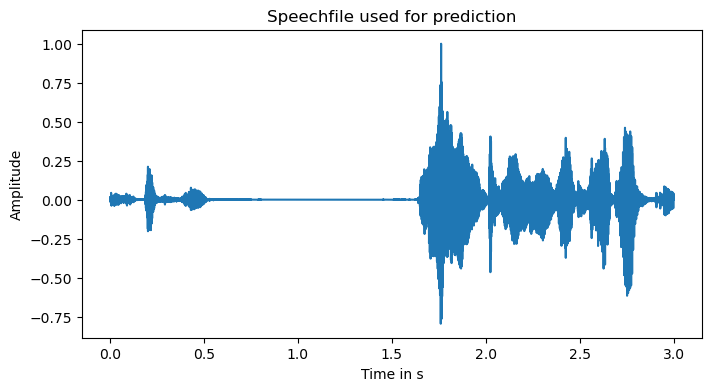

Model: "PostNet_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_118 (Conv1D)         (None, 132300, 64)        384       
                                                                 
 activation_111 (Activation)  (None, 132300, 64)       0         
                                                                 
 conv1d_119 (Conv1D)         (None, 132300, 64)        20544     
                                                                 
 activation_112 (Activation)  (None, 132300, 64)       0         
                                                                 
 conv1d_120 (Conv1D)         (None, 132300, 1)         65        
                                                                 
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
_________________________________________________________________


In [163]:
# initialize log_dir
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# make directory if not exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


#--------------------------------------------
# define callbacks

save_callback = keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint',
    save_best_only=False,
    monitor='val_loss',
    verbose=0)

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir= log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=1)

# early_stopping_callback = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     verbose=1)


# get speechfile for prediction
speech_for_predicition = set_speechfile(test_dataset, log_dir)

#--------------------------------------------
# define custom callback
class CustomCallback(keras.callbacks.Callback):
     
    # define functions to happen during training after each epoch
    def on_epoch_end(self, epoch, logs=None):
        
        # save predicted audio file after each epoch to disk
        # get audio file from model prediciton
        audio = self.model.predict(speech_for_predicition)

        # change shape to (len(audio), 1)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.squeeze(audio, axis=-1).numpy()
        #print(audio.shape)

        # normalize audio with numpy
        #audio = librosa.util.normalize(audio).astype(np.float32)
        audio = audio.astype(np.float32)

        # save plot to disk
        plt.figure(figsize=(8, 4))
        x = np.arange(0, len(audio)/44100, 1/44100)
        plt.plot(x, audio)
        plt.title('Audiofile')
        plt.xlabel('Time in s')
        plt.ylabel('Amplitude')
        plt.savefig(log_dir + '/_audiofile_epoch' + str(epoch+1) + '.png')
        plt.close()

        # write audio file to disk (16-bit PCM WAV)
        write(log_dir + '/_audiofile_epoch' + str(epoch+1) + '.wav', 44100, float2pcm(audio))


#--------------------------------------------
# get model
model = build_model(input_shape = input_shape)

# compile model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = tf.keras.losses.MeanSquaredError())

model.summary()


In [164]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

# Model fit and save

In [165]:
# fit model
history = model.fit(train_dataset,
                    epochs=config['n_epochs'],
                    validation_data=test_dataset,
                    callbacks=[save_callback, tensorboard_callback, CustomCallback()])

# save model
model.save('./model.keras')

# save history
with open('./history.json', 'w+') as fp:
    json.dump(history.history, fp, sort_keys=True, indent=4)


# call def to save audio to summaries
save_audio_to_summaries(log_dir)


Epoch 1/20


     38/Unknown - 111s 3s/step - loss: 0.0213 - mean_squared_error: 0.0213

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 130s 3s/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0162 - val_mean_squared_error: 0.0161
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.0210

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 129s 3s/step - loss: 0.0211 - mean_squared_error: 0.0210 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.0216

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 126s 3s/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0156 - val_mean_squared_error: 0.0157
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.0207

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 123s 3s/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 5/20
38/38 [==============================] - ETA: 0s - loss: 0.0203 - mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 126s 3s/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 6/20
38/38 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.0207

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 125s 3s/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 7/20
38/38 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 126s 3s/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0160 - val_mean_squared_error: 0.0159
Epoch 8/20
38/38 [==============================] - ETA: 0s - loss: 0.0214 - mean_squared_error: 0.0214

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 127s 3s/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0164 - val_mean_squared_error: 0.0163
Epoch 9/20
38/38 [==============================] - ETA: 0s - loss: 0.0210 - mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 129s 3s/step - loss: 0.0210 - mean_squared_error: 0.0211 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 10/20
38/38 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


38/38 [==============================] - 127s 3s/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0164 - val_mean_squared_error: 0.0165
Epoch 11/20
 9/38 [======>.......................] - ETA: 1:22 - loss: 0.0214 - mean_squared_error: 0.0214

KeyboardInterrupt: 

# check history and simple plot

In [ ]:
# open history
with open('./history.json', 'r') as fp:
  history = json.load(fp)

# check out history keys
print(history.keys())

# simple plot losses
train_loss = history['loss']
eval_loss = history['val_loss']
mae = history['mean_absolute_error']
val_mae = history['val_mean_absolute_error']



fig2 = plt.figure()
plt.plot(range(config['n_epochs']), train_loss, label='train')
plt.plot(range(config['n_epochs']), eval_loss, label='eval')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Custom Loss')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  


fig3 = plt.figure()
plt.plot(range(config['n_epochs']), mae, label='train')
plt.plot(range(config['n_epochs']), val_mae, label='eval')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


KeyError: 'mean_absolute_error'

# Tensorboard

In [ ]:
%tensorboard --logdir logs

# load model from disk and predict

In [ ]:
# # load model
reconstructed_model = keras.models.load_model('./model.keras', compile=False)
#reconstructed_model.summary()

# get audio file from model prediciton
audio = reconstructed_model.predict(speech_for_predicition)



# change shape to (len(audio), 1)
audio = tf.squeeze(audio, axis=-1)
audio = tf.squeeze(audio, axis=-1)



print(audio.dtype)
print(audio.shape)



4135/4135 [==============================] - 5s 1ms/step
<dtype: 'float32'>
(132300,)


In [ ]:
print(audio)

# normalize audio with numpy
# audio = librosa.util.normalize(audio)

# normalize audio with tensorflow
audio = tf.math.divide(audio, tf.math.reduce_max(audio))
print(audio)


tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(132300,), dtype=float32)
tf.Tensor([nan nan nan ... nan nan nan], shape=(132300,), dtype=float32)


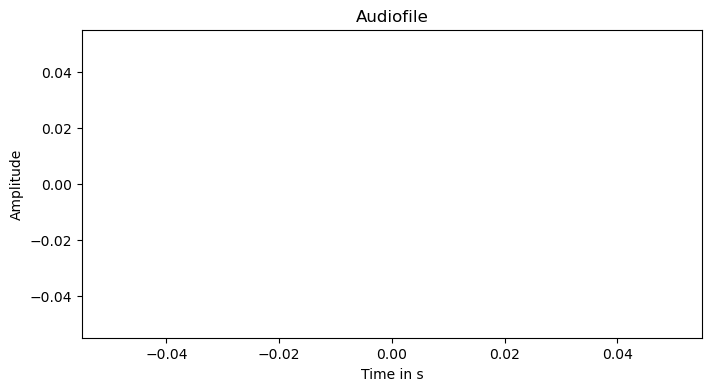

In [ ]:

# save plot to disk
plt.figure(figsize=(8, 4))
x = np.arange(0, len(audio)/44100, 1/44100)
plt.plot(x, audio)
plt.title('Audiofile')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.savefig(log_dir + '/_audiofile_Reconstructed_model..png')
plt.show()

# write audio file to disk (16-bit PCM WAV)
write(log_dir + '/_audiofile_Reconstructed_model.wav', 44100, audio.numpy())

# look at data

In [ ]:
# # look at some example data from train dataset
# wavs = train_dataset.unbatch().as_numpy_iterator()
# noisy = []
# gt = []

# # Setup Subplot
# nrows, ncols = 2, 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# # iterate over dataset
# for i, sample in enumerate(wavs):
    
#     # get the column and row by modulo and remainder
#     j = i % ncols
#     k = int(i / ncols)
    
#     # extract noisy and produced speech file from tensors
#     wave = sample[0]
#     ground_truth = sample[1]
        
#     # plot files
#     librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
#     librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
#     ax[k][j].legend()
#     ax[k][j].axis('on')
#     ax[k][j].set_title('10s speech')  

#     # save speech to arrays
#     noisy.append(np.squeeze(wave))
#     gt.append(np.squeeze(ground_truth))
    
#     if i+1 == ncols*nrows:
#         break
    
# # adjust whitespace in between subplots        
# plt.subplots_adjust(hspace=0.25, wspace=0.15)
# plt.show()


# # listen to the audio samples
# for i in range(len(gt)):
#     print(f'----------- {i+1}. speechsnippet ---------------')
#     print('')
#     print(f'Voicefixer file')
#     pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
#     print(f'corresponding produced file')
#     pd.display(pd.Audio(gt[i].T, rate=config['sr']))
#     print('')